# Spytorch tutorial copied/pasted bits

In [38]:
import os

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

try:
    import ipywidgets as widgets
except ImportError:
    widgets = None

import torch
import torch.nn as nn

dtype = torch.float

# Check whether a GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")     
else:
    device = torch.device("cpu")

In [36]:
# The coarse network structure is dicated by the Fashion MNIST dataset. 
nb_inputs  = 28*28
nb_hidden  = 100
nb_outputs = 10

time_step = 1e-3
nb_steps  = 100

batch_size = 256

In [ ]:
# Standardize data
# x_train = torch.tensor(train_dataset.train_data, device=device, dtype=dtype)
x_train = np.array(train_dataset.data, dtype=np.float)
x_train = x_train.reshape(x_train.shape[0],-1)/255
# x_test = torch.tensor(test_dataset.test_data, device=device, dtype=dtype)
x_test = np.array(test_dataset.data, dtype=np.float)
x_test = x_test.reshape(x_test.shape[0],-1)/255

# y_train = torch.tensor(train_dataset.train_labels, device=device, dtype=dtype)
# y_test  = torch.tensor(test_dataset.test_labels, device=device, dtype=dtype)
y_train = np.array(train_dataset.targets, dtype=np.int)
y_test  = np.array(test_dataset.targets, dtype=np.int)

In [ ]:
tau_mem = 10e-3
tau_syn = 5e-3

alpha   = float(np.exp(-time_step/tau_syn))
beta    = float(np.exp(-time_step/tau_mem))

weight_scale = 0.2

w1 = torch.empty((nb_inputs, nb_hidden),  device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w1, mean=0.0, std=weight_scale/np.sqrt(nb_inputs))

w2 = torch.empty((nb_hidden, nb_outputs), device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w2, mean=0.0, std=weight_scale/np.sqrt(nb_hidden))

print("init done")

def plot_voltage_traces(mem, spk=None, dim=(3,5), spike_height=5):
    gs=GridSpec(*dim)
    if spk is not None:
        dat = 1.0*mem
        dat[spk>0.0] = spike_height
        dat = dat.detach().cpu().numpy()
    else:
        dat = mem.detach().cpu().numpy()
    for i in range(np.prod(dim)):
        if i==0: a0=ax=plt.subplot(gs[i])
        else: ax=plt.subplot(gs[i],sharey=a0)
        ax.plot(dat[i])
        ax.axis("off")
        
class SurrGradSpike(torch.autograd.Function):
    """
    Here we implement our spiking nonlinearity which also implements 
    the surrogate gradient. By subclassing torch.autograd.Function, 
    we will be able to use all of PyTorch's autograd functionality.
    Here we use the normalized negative part of a fast sigmoid 
    as this was done in Zenke & Ganguli (2018).
    """
    
    scale = 100.0 # controls steepness of surrogate gradient

    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we compute a step function of the input Tensor
        and return it. ctx is a context object that we use to stash information which 
        we need to later backpropagate our error signals. To achieve this we use the 
        ctx.save_for_backward method.
        """
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor we need to compute the 
        surrogate gradient of the loss with respect to the input. 
        Here we use the normalized negative part of a fast sigmoid 
        as this was done in Zenke & Ganguli (2018).
        """
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad = grad_input/(SurrGradSpike.scale*torch.abs(input)+1.0)**2
        return grad
    
# here we overwrite our naive spike function by the "SurrGradSpike" nonlinearity which implements a surrogate gradient
spike_fn  = SurrGradSpike.apply

def run_snn(inputs):
    h1 = torch.einsum("abc,cd->abd", (inputs, w1))
    syn = torch.zeros((batch_size,nb_hidden), device=device, dtype=dtype)
    mem = torch.zeros((batch_size,nb_hidden), device=device, dtype=dtype)

    mem_rec = []
    spk_rec = []

    # Compute hidden layer activity
    for t in range(nb_steps):
        mthr = mem-1.0
        out = spike_fn(mthr)
        rst = out.detach() # We do not want to backprop through the reset

        new_syn = alpha*syn +h1[:,t]
        new_mem = (beta*mem +syn)*(1.0-rst)

        mem_rec.append(mem)
        spk_rec.append(out)
        
        mem = new_mem
        syn = new_syn

    mem_rec = torch.stack(mem_rec,dim=1)
    spk_rec = torch.stack(spk_rec,dim=1)

    # Readout layer
    h2= torch.einsum("abc,cd->abd", (spk_rec, w2))
    flt = torch.zeros((batch_size,nb_outputs), device=device, dtype=dtype)
    out = torch.zeros((batch_size,nb_outputs), device=device, dtype=dtype)
    out_rec = [out]
    for t in range(nb_steps):
        new_flt = alpha*flt +h2[:,t]
        new_out = beta*out +flt

        flt = new_flt
        out = new_out

        out_rec.append(out)

    out_rec = torch.stack(out_rec,dim=1)
    other_recs = [mem_rec, spk_rec]
    return out_rec, other_recs

def train(x_data, y_data, lr=1e-3, nb_epochs=10):
    params = [w1,w2]
    optimizer = torch.optim.Adamax(params, lr=lr, betas=(0.9,0.999))

    log_softmax_fn = nn.LogSoftmax(dim=1)
    loss_fn = nn.NLLLoss()
    
    loss_hist = []
    for e in range(nb_epochs):
        local_loss = []
        for x_local, y_local in sparse_data_generator(x_data, y_data, batch_size, nb_steps, nb_inputs):
            output,recs = run_snn(x_local.to_dense())
            _,spks=recs
            m,_=torch.max(output,1)
            log_p_y = log_softmax_fn(m)
            
            # Here we set up our regularizer loss
            # The strength paramters here are merely a guess and there should be ample room for improvement by
            # tuning these paramters.
            reg_loss = 1e-5*torch.sum(spks) # L1 loss on total number of spikes
            reg_loss += 1e-5*torch.mean(torch.sum(torch.sum(spks,dim=0),dim=0)**2) # L2 loss on spikes per neuron
            
            # Here we combine supervised loss and the regularizer
            loss_val = loss_fn(log_p_y, y_local) + reg_loss

            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()
            local_loss.append(loss_val.item())
        mean_loss = np.mean(local_loss)
        print("Epoch %i: loss=%.5f"%(e+1,mean_loss))
        loss_hist.append(mean_loss)
        
    return loss_hist
        
        
def compute_classification_accuracy(x_data, y_data):
    """ Computes classification accuracy on supplied data in batches. """
    accs = []
    for x_local, y_local in sparse_data_generator(x_data, y_data, batch_size, nb_steps, nb_inputs, shuffle=False):
        output,_ = run_snn(x_local.to_dense())
        m,_= torch.max(output,1) # max over time
        _,am=torch.max(m,1)      # argmax over output units
        tmp = np.mean((y_local==am).detach().cpu().numpy()) # compare to labels
        accs.append(tmp)
    return np.mean(accs)

loss_hist = train(x_train, y_train, lr=2e-4, nb_epochs=30)

print("Training accuracy: %.3f"%(compute_classification_accuracy(x_train,y_train)))
print("Test accuracy: %.3f"%(compute_classification_accuracy(x_test,y_test)))

# Sound localisation stimuli

The following function creates a set of stimuli that can be used for training or testing. It returns two arrays ``ipd`` and ``spikes``. ``ipd`` is an array of length ``num_samples`` that gives the true IPD, and ``spikes`` is an array of 0 (no spike) and 1 (spike) of shape ``(num_samples, 2*anf_per_ear, duration_steps)`` where ``anf_per_ear`` is how many neurons there are receiving the same signal (but generating independent Poisson noise) there are for each ear, and ``duration_steps`` is the number of time steps there are in the stimulus.

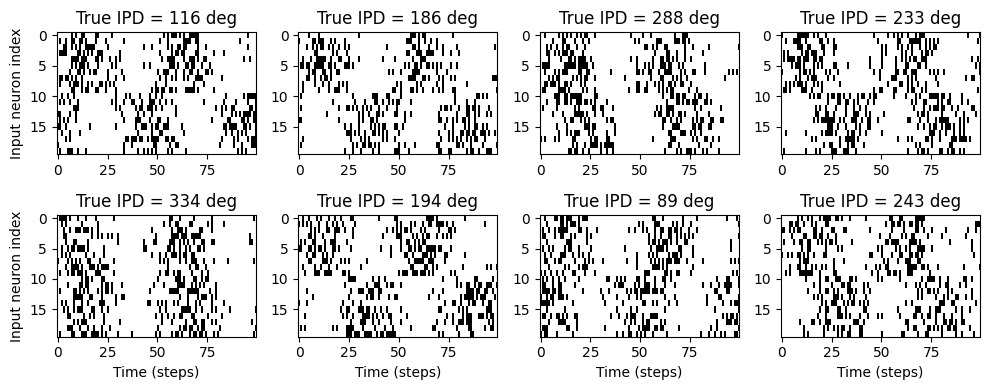

In [94]:
second = 1
ms = 1e-3
Hz = 1

def input_signal(ipd,                        # array of true IPDs
                 anf_per_ear=10,              # repeats of each ear with independent noise
                 envelope_power=1,           # higher values make sharper envelopes, easier
                 rate_max=400*Hz,            # maximum Poisson firing rate
                 f=20*Hz,                    # stimulus frequency
                 duration=.1*second,         # stimulus duration
                 dt=1*ms,                    # simulation timestep
                ):
    num_samples = len(ipd)
    duration_steps = int(np.round(duration/dt))
    T = np.arange(duration_steps)*dt
    phi = 2*np.pi*f*T
    theta = np.zeros((num_samples, 2*anf_per_ear, duration_steps))
    
    theta[:, :anf_per_ear, :] = phi[np.newaxis, np.newaxis, :]
    theta[:, anf_per_ear:, :] = phi[np.newaxis, np.newaxis, :]+ipd[:, np.newaxis, np.newaxis]
    spikes = np.random.rand(num_samples, 2*anf_per_ear, duration_steps)<rate_max*dt*(0.5*(1+np.sin(theta)))**envelope_power
    return spikes

def random_ipd_input_signal(num_samples, **kwds):
    ipd = np.random.rand(num_samples)*2*np.pi
    spikes = input_signal(ipd, **kwds)
    return ipd, spikes

ipd, spikes = random_ipd_input_signal(8)
plt.figure(figsize=(10, 4), dpi=100)
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(spikes[i, :, :], aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r)
    plt.title(f'True IPD = {int(ipd[i]*180/np.pi)} deg')
    if i>=4:
        plt.xlabel('Time (steps)')
    if i%4==0:
        plt.ylabel('Input neuron index')
plt.tight_layout()

Now with this, the aim is to take these input spikes and infer the IPD. We can do this either by discretising and using a classification approach, or with a regression approach.